## Goal: 
#### Permutation bootstrap with fourier for dominant frequency to determine probability of osciliations at wb frequency if data is randomly shuffled

In [3]:
import numpy as np
import pandas
import glob
import scipy.io
import math
from scipy import fftpack
import itertools

# Plot parameters 
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Times',
        'weight' : 'heavy',
        'size'   : 16}

matplotlib.rc('font', **font)

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


In [4]:
# Outfront variables

acceptable_trials = ['m07_t01_15', 'm07_t03_15', 'm07_t06_15','m10_t02_16','m11_t02_16','m11_t04_16',
                   'm12_t02_16', 'm14_t03_16','m14_t05_16', 'm15_t01_16', 'm15_t03_16']
columns = ['D10', 'M6_c', 'M3_c','A51_c', 'A59_c', 'I20_I10']

f_s = 200 # signal frequency; Hz
perm_num = 1000 # number of times to shuffle the data


In [5]:
# Create an array for a multi - level index; we will store in a dataframe the power of the FFT around the wb frequency for each data col, each moth in this array. 
ar1 = []
ar2 = []
for t in acceptable_trials:
    ar1_ = []
    ar2_ = []
    for col in columns:
        ar1_.append(col)
        ar2_.append(t)
    ar1.append(ar1_)
    ar2.append(ar2_)

ar1 = list(itertools.chain.from_iterable(ar1))
ar2 = list(itertools.chain.from_iterable(ar2))

ar = [ar2, ar1]
ar = list(zip(*ar))
index = pandas.MultiIndex.from_tuples(ar, names=['moth', 'column'])

In [6]:
# Create a data frame in which to store the power around wingbeat frequency for each permutation, each column and each trial
perm_bootstrap = pandas.DataFrame(np.zeros((perm_num, len(ar))), columns=index)
pre_bootstrap = pandas.DataFrame(np.zeros((1, len(ar))), columns=index)
percent_bootstrap = pandas.DataFrame(np.zeros((1, len(ar))), columns=index)
perm_bootstrap.head()

moth   m07_t01_15                               m07_t03_15                  \
column        D10 M6_c M3_c A51_c A59_c I20_I10        D10 M6_c M3_c A51_c   
0             0.0  0.0  0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   
1             0.0  0.0  0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   
2             0.0  0.0  0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   
3             0.0  0.0  0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   
4             0.0  0.0  0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   

moth    ... m15_t01_16                     m15_t03_16                        \
column  ...       M3_c A51_c A59_c I20_I10        D10 M6_c M3_c A51_c A59_c   
0       ...        0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   0.0   
1       ...        0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   0.0   
2       ...        0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   0.0   
3       ...        0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   0.0   
4       ...        0.0   0.0   0.0     0.0        0.0  0.0  0.0   0.0   0.0   

moth            
column I20_I10  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 66 columns]

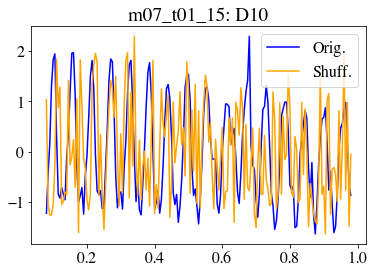

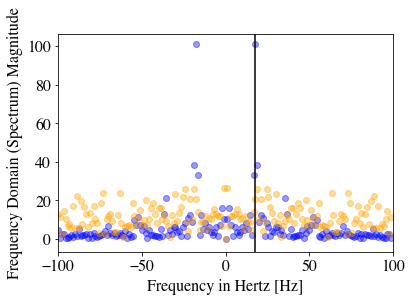

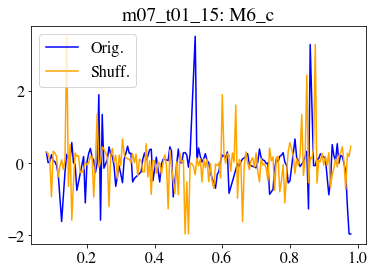

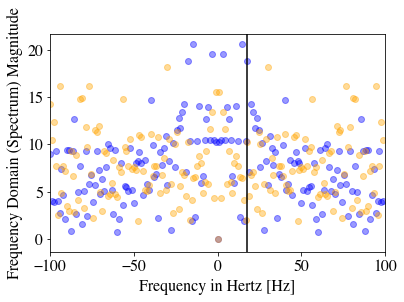

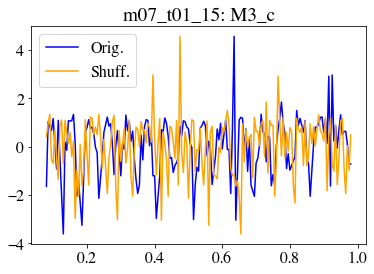

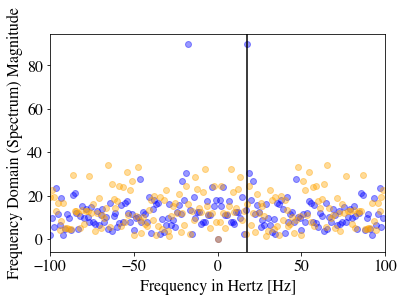

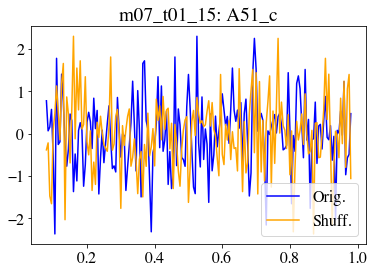

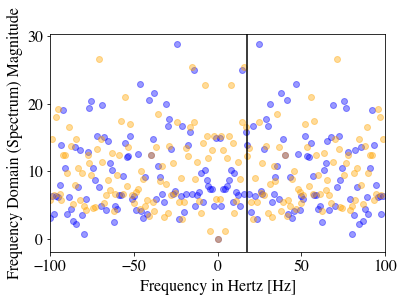

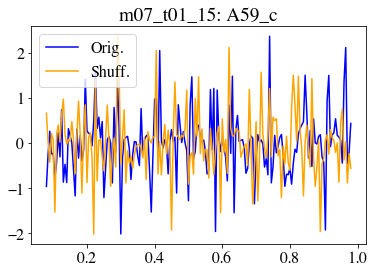

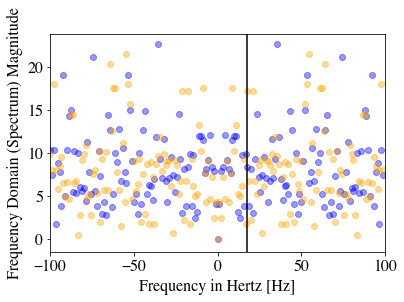

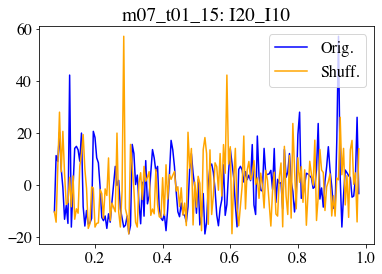

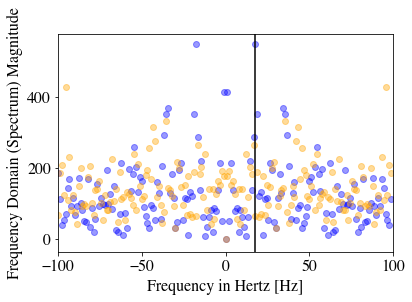

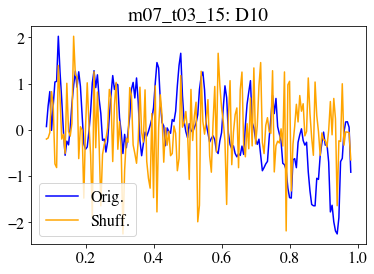

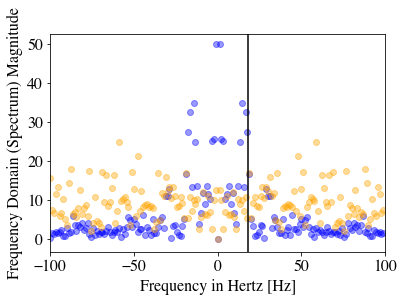

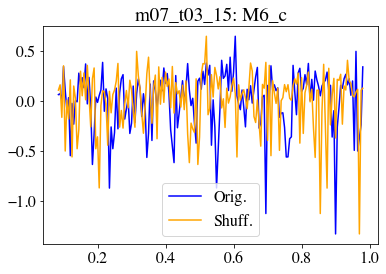

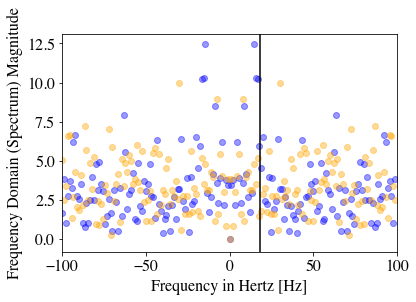

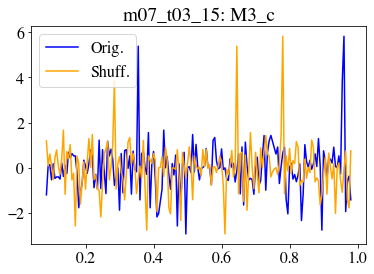

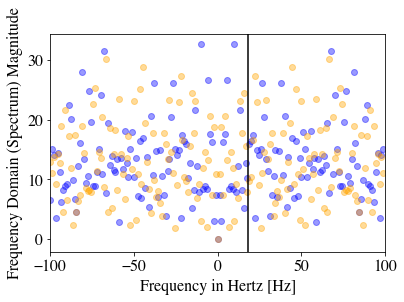

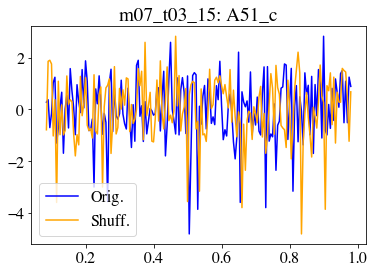

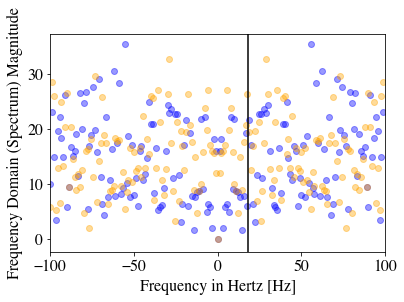

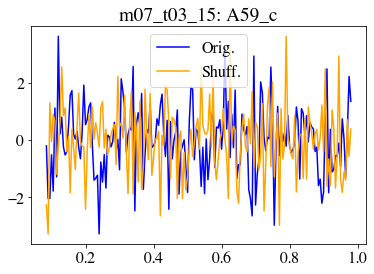

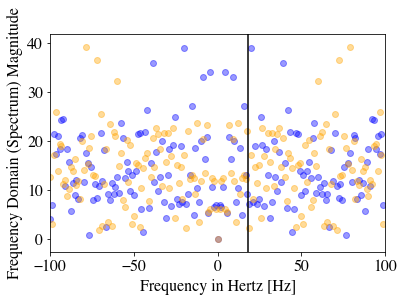

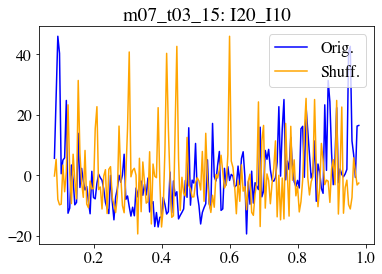

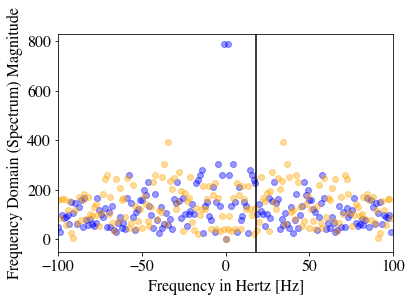

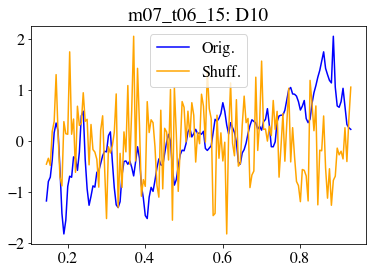

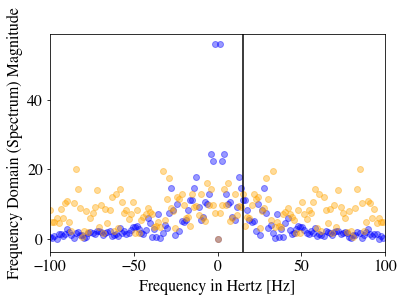

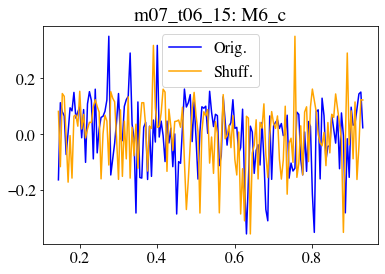

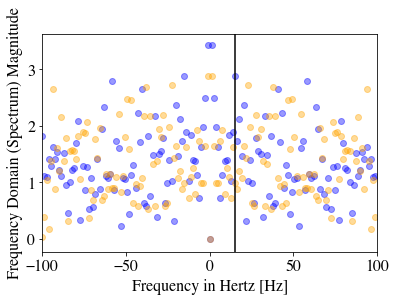

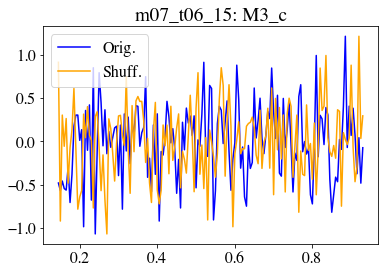

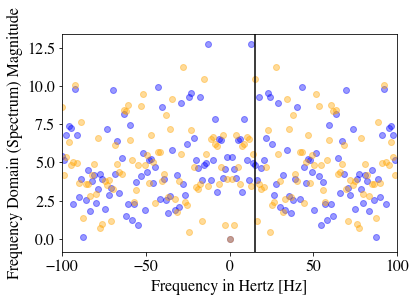

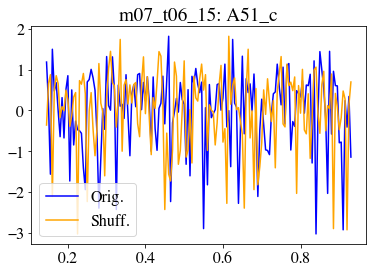

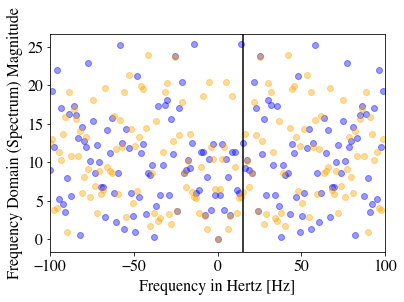

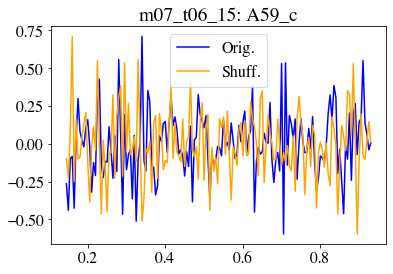

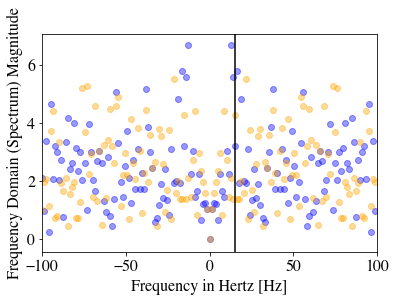

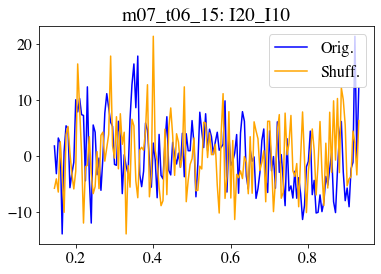

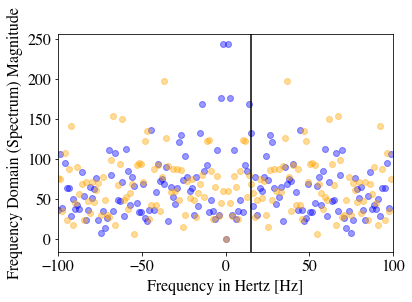

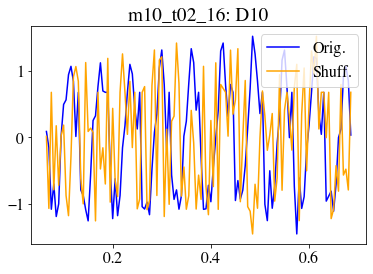

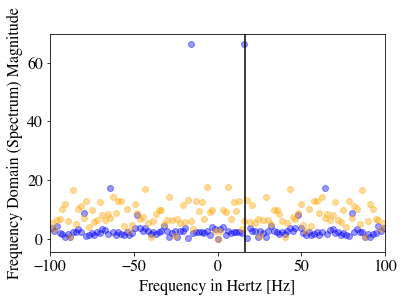

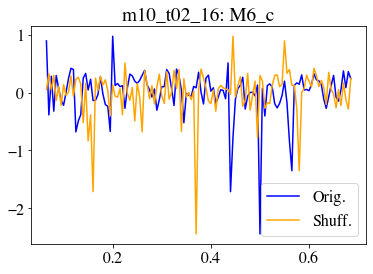

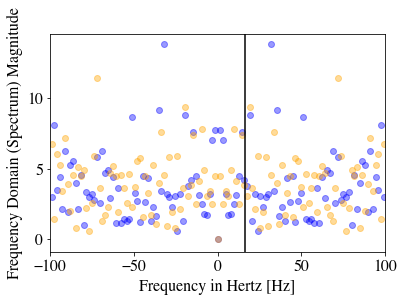

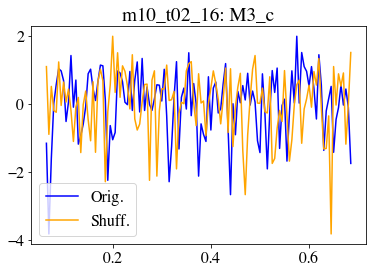

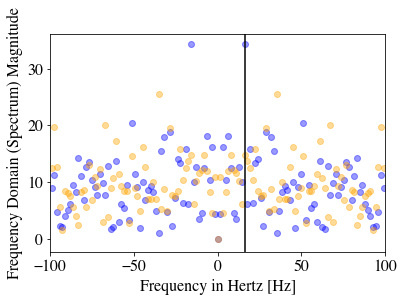

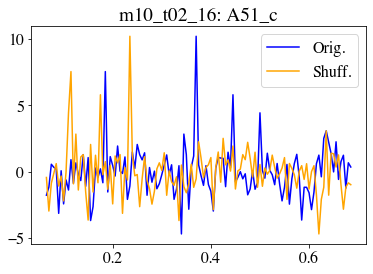

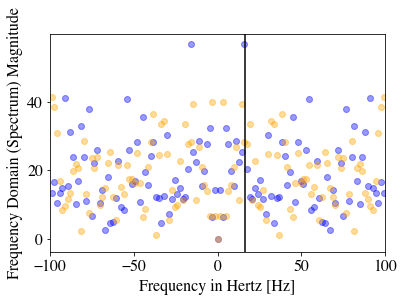

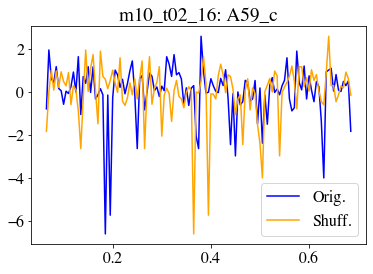

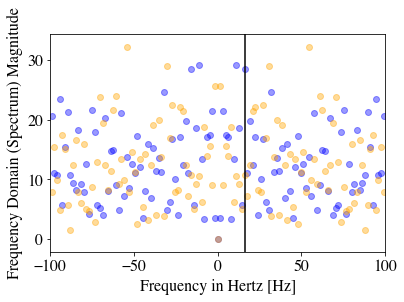

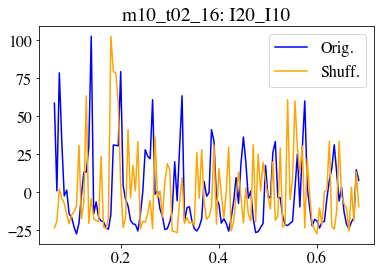

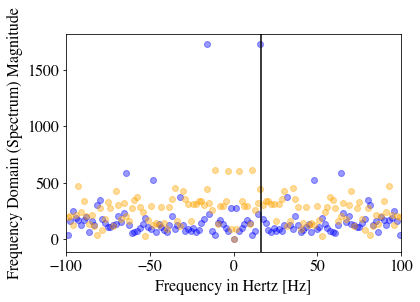

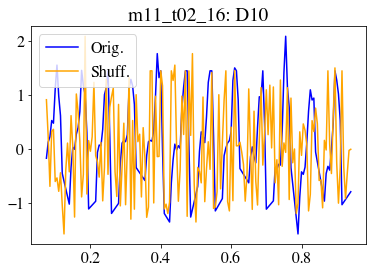

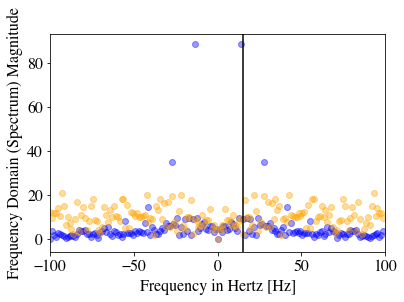

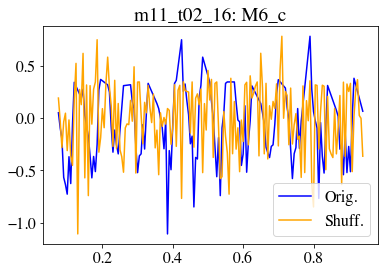

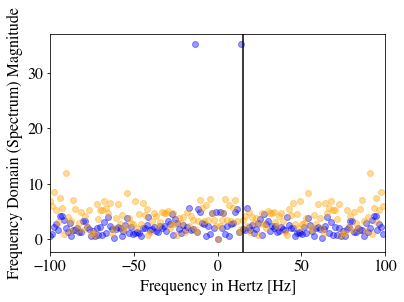

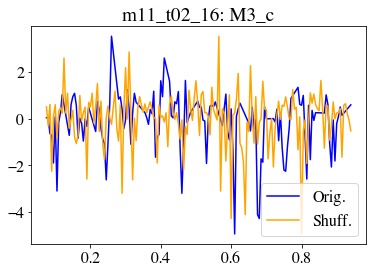

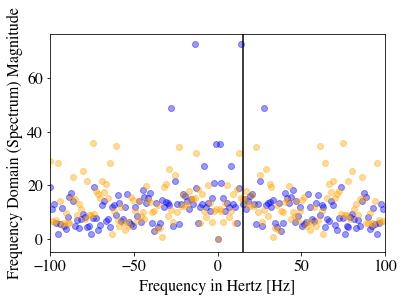

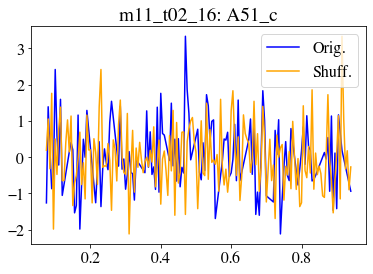

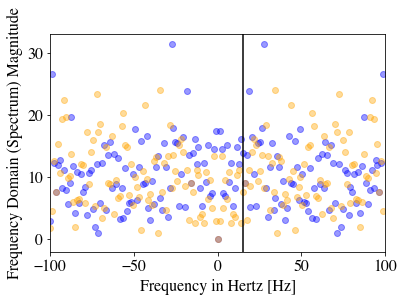

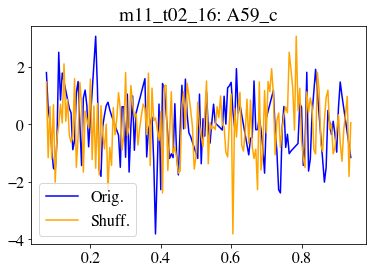

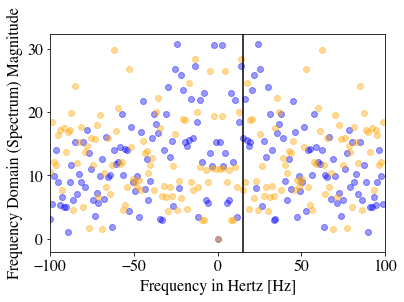

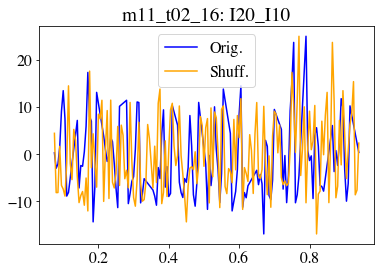

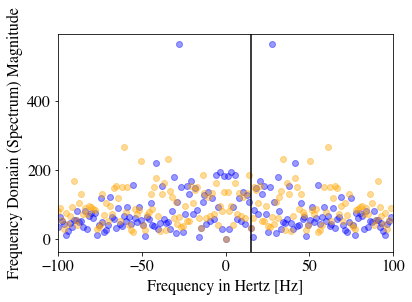

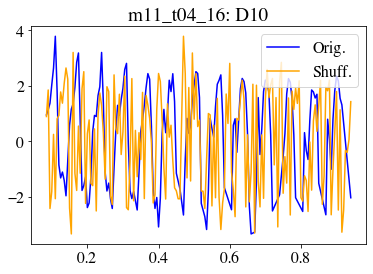

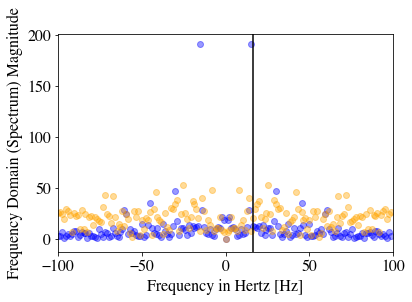

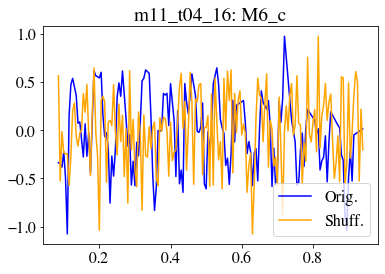

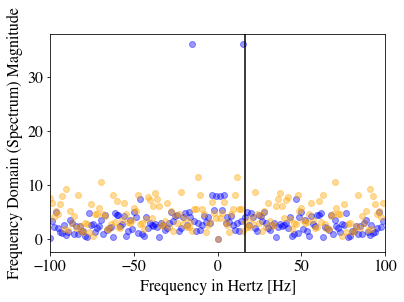

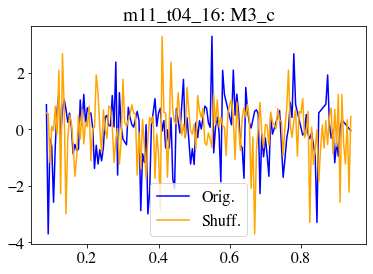

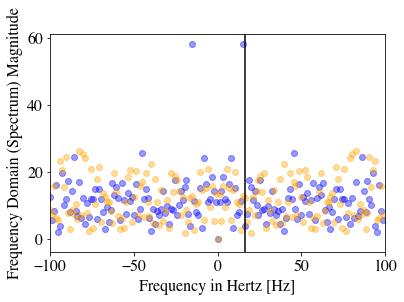

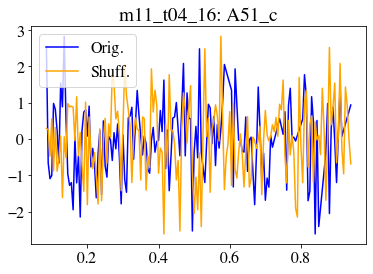

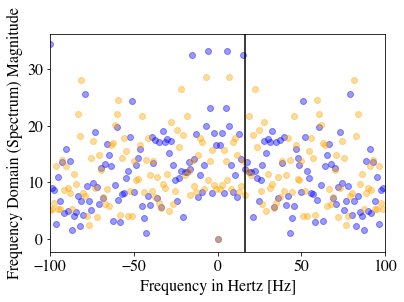

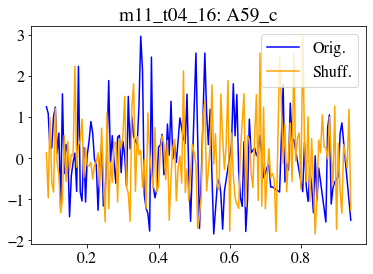

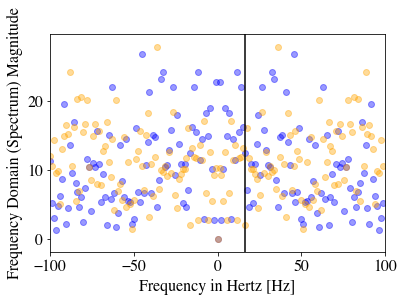

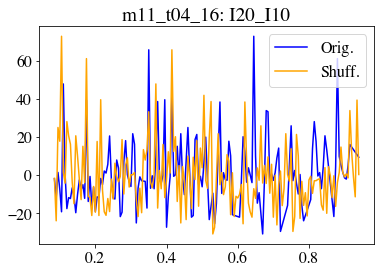

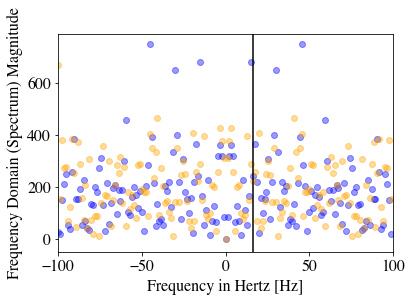

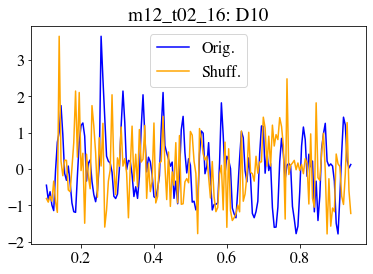

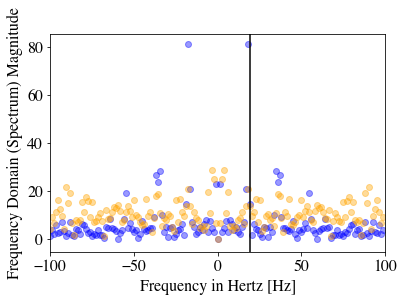

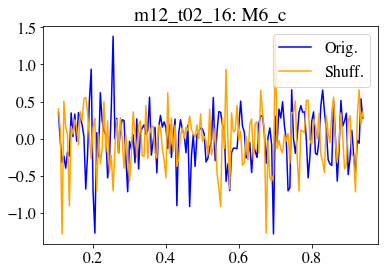

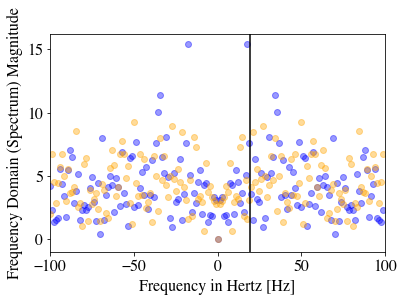

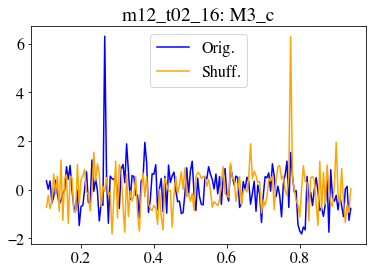

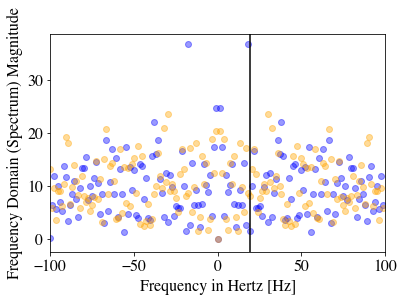

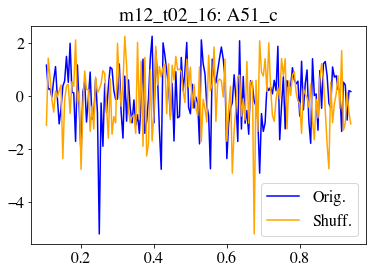

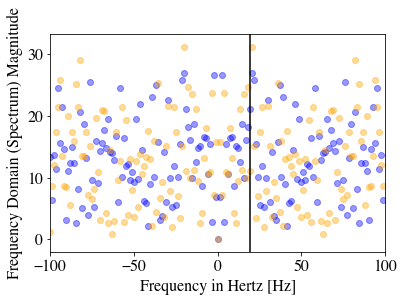

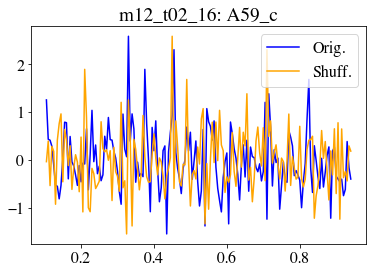

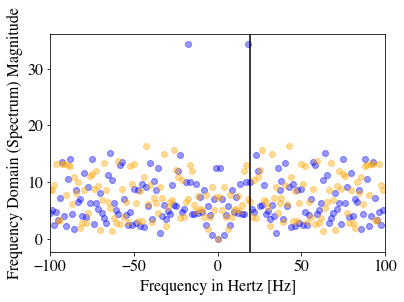

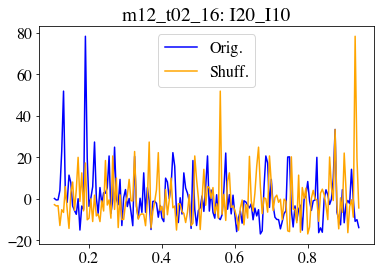

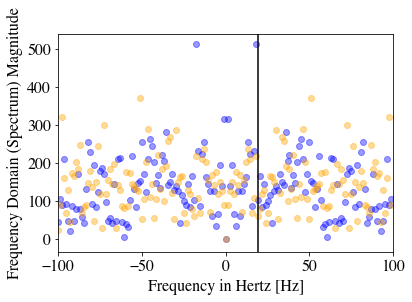

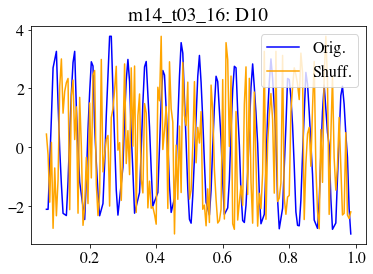

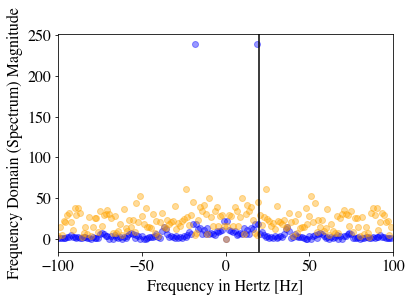

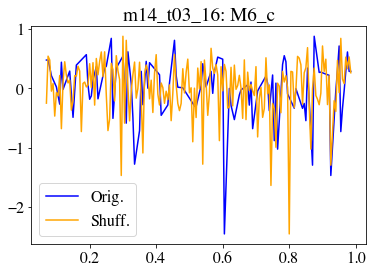

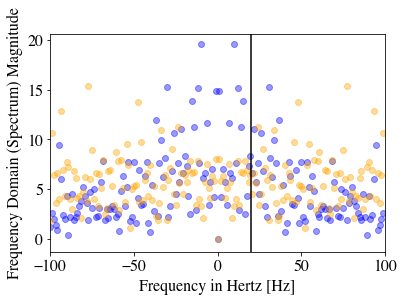

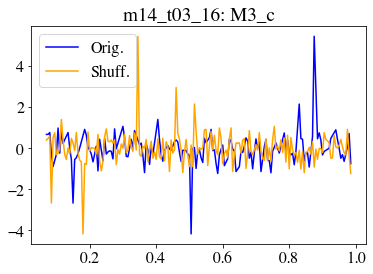

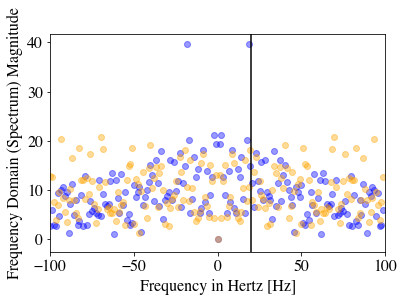

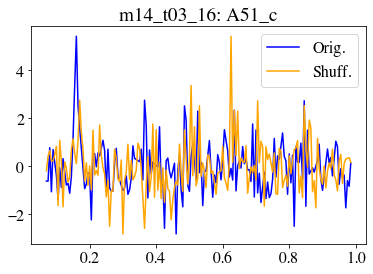

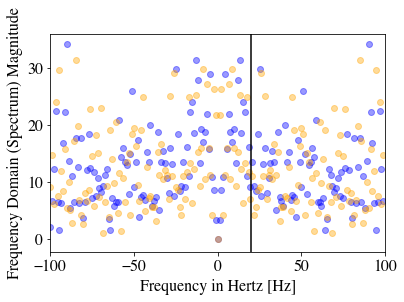

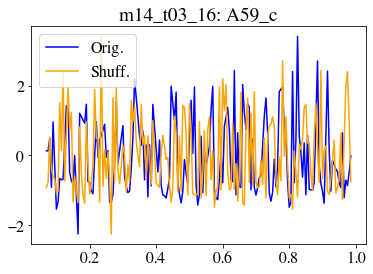

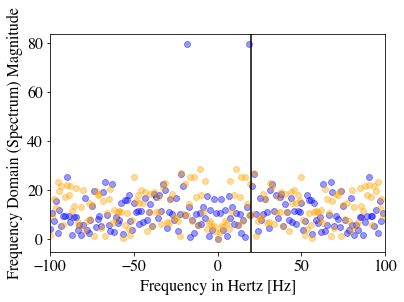

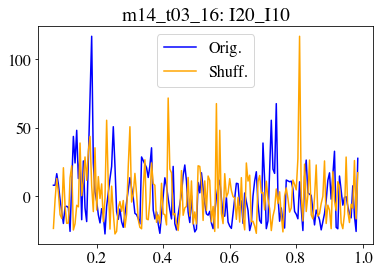

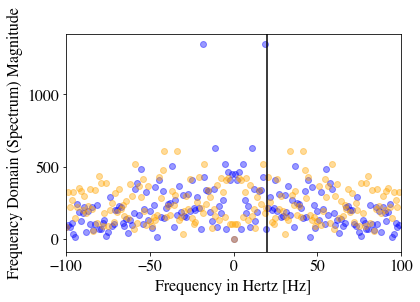

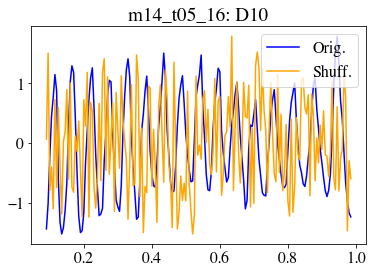

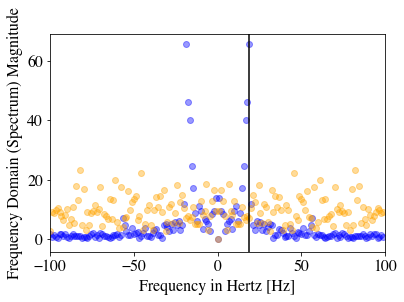

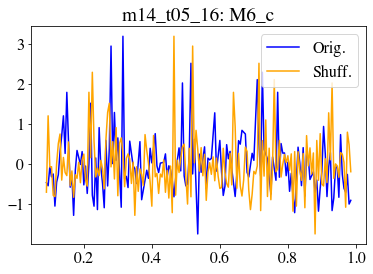

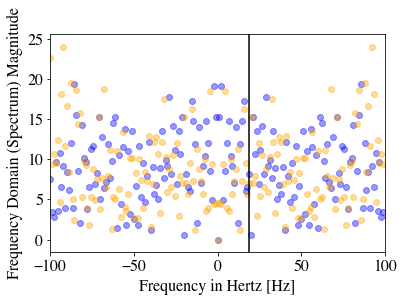

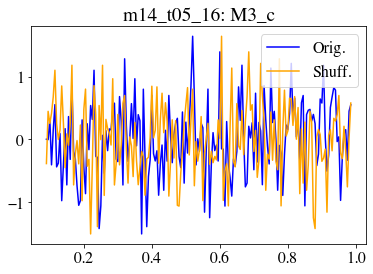

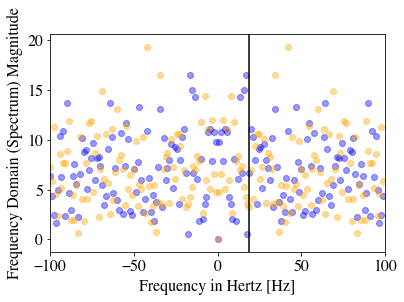

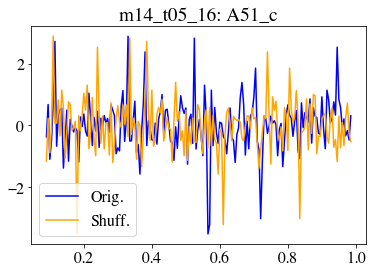

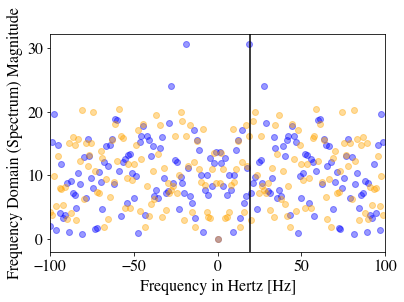

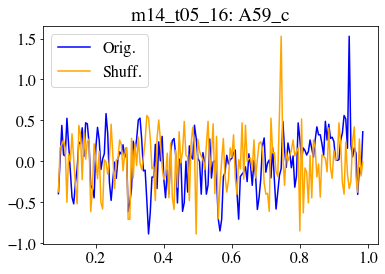

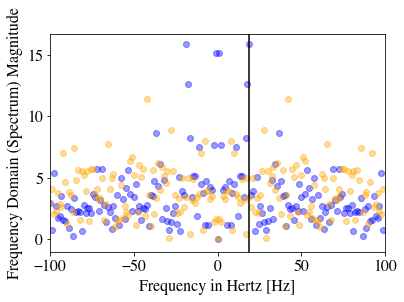

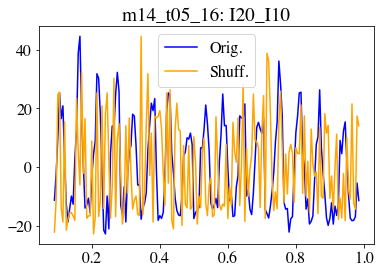

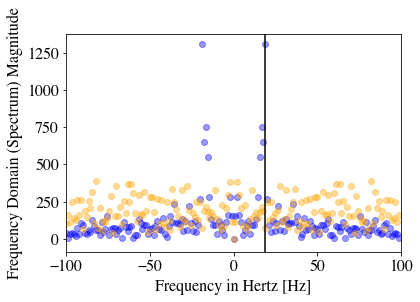

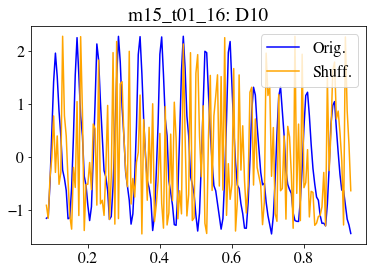

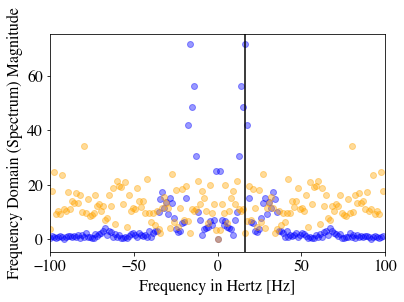

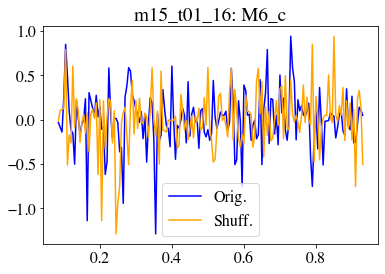

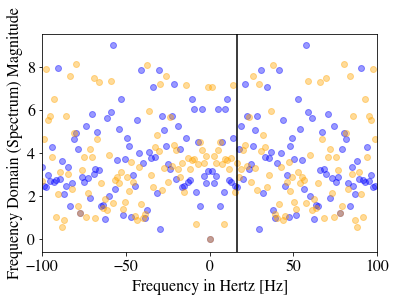

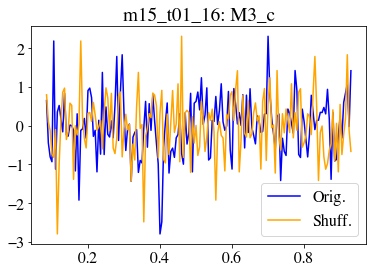

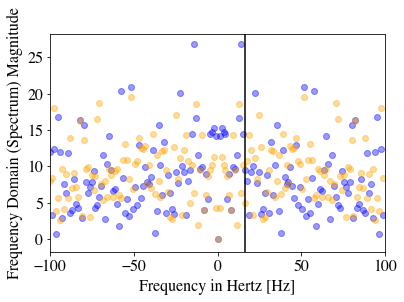

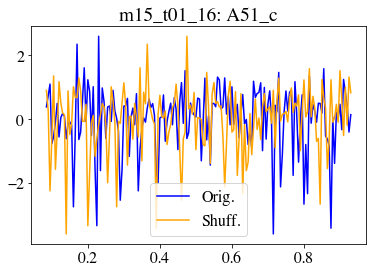

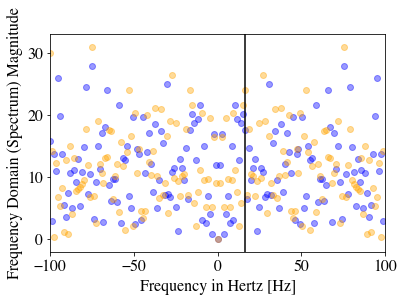

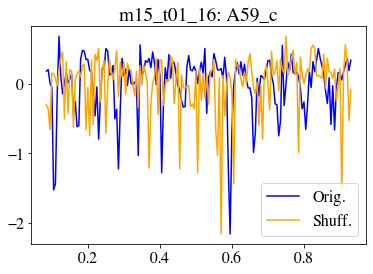

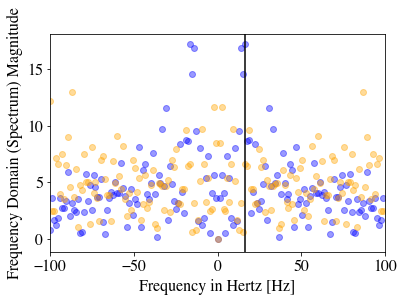

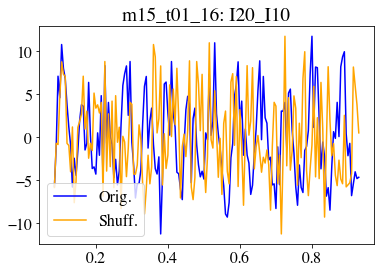

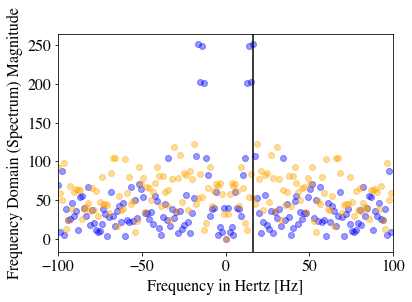

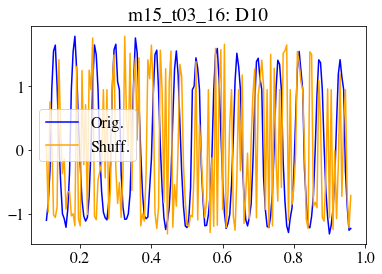

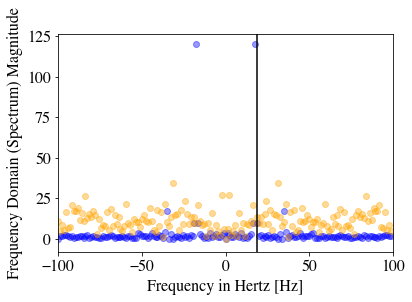

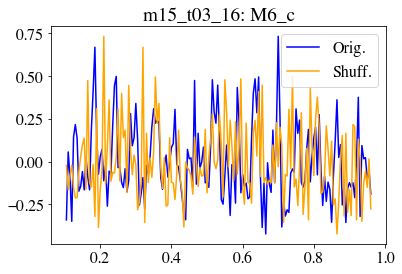

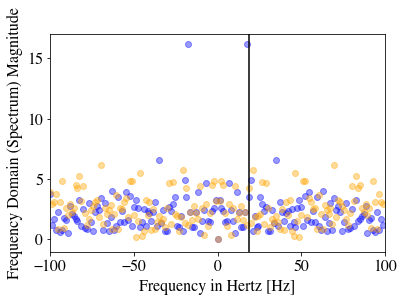

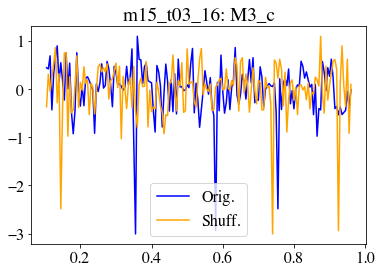

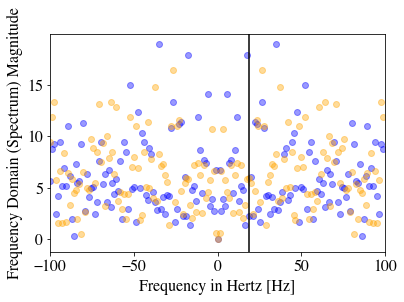

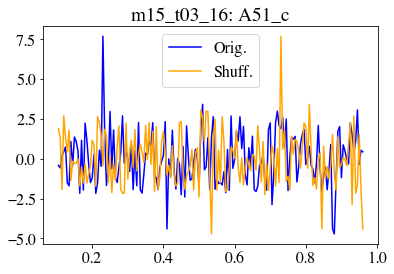

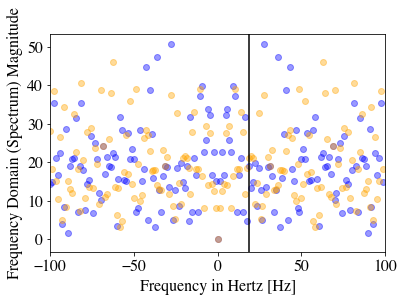

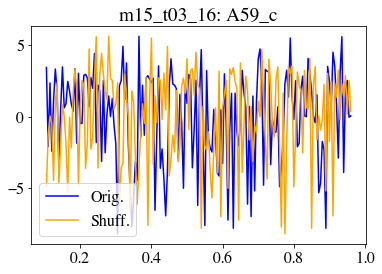

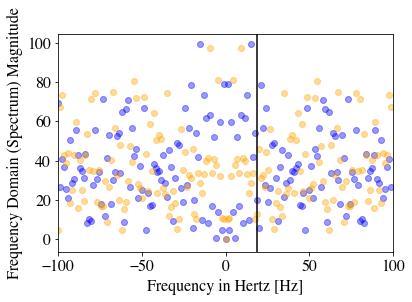

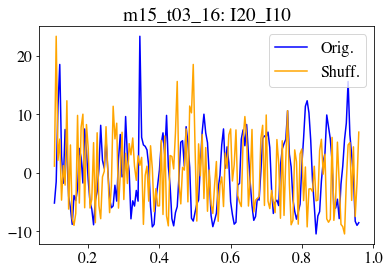

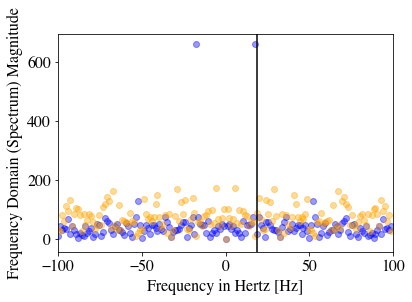

In [7]:
for trial in acceptable_trials:
    path = '../DataProcessing/ProcessedData/' + trial + '_det.csv'
    df = pandas.read_csv(path)
    t = df.seconds
    f = df.ISI.max()/(df.seconds.max()-df.seconds.min())
    
    for col in columns:
        
        sig = df[col].interpolate(limit_direction = 'both') # This handles it if there's a nan in the first row
        
        sig = 100*(sig/sig.mean()) - 100 # convert to percent change from mean
        sig_sh = sig.copy() # Create a copy since shuffle operates in place
        SIG = fftpack.fft(sig)
        freqs = fftpack.fftfreq(len(sig)) * f_s
        
        proc = pandas.DataFrame({'SIG_abs':np.abs(SIG), 'SIG_sh_abs':np.zeros(len(np.abs(SIG))), 'freqs':freqs})
        
        # Run the permutation perm_num times
        for i in np.arange(0, perm_num):
            np.random.shuffle(sig_sh)
            SIG_sh = fftpack.fft(sig_sh)
            proc['SIG_sh_abs'] = np.abs(SIG_sh)
            proc_ = proc.where(proc.freqs > f - 2).where(proc.freqs < f + 2).dropna(how = 'all').reset_index(drop = 'True')
            perm_bootstrap[trial, col].loc[i] = proc_.SIG_sh_abs.sum()
            
        pre_bootstrap[trial, col].loc[0] = proc_.SIG_abs.sum()
        
        # Plot the last permutation and original data comparison
        plt.plot(t,sig, c = 'blue', label = 'Orig.')
        plt.plot(t, sig_sh, c = 'orange', label = 'Shuff.')
        plt.title(trial + ': ' + col)
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots()
        ax.axvline(f, c = 'black')
        ax.scatter(freqs, np.abs(SIG), alpha = .4, color = 'blue', label = 'Orig. freq.s')
        ax.scatter(freqs, np.abs(SIG_sh), color = 'orange', alpha = .4, label = 'Shuff. freq.s')
        ax.set_xlabel('Frequency in Hertz [Hz]')
        ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax.set_xlim(-f_s / 2, f_s / 2)
        plt.show()
        

In [8]:
# Compute the percentage of the permutations that had a power equal to or greater than the actual signal 
for trial in acceptable_trials:
    for col in columns:
        count = len(perm_bootstrap[trial, col].where(perm_bootstrap[trial, col] > pre_bootstrap[trial, col][0]).dropna(how = 'all'))
        percent_bootstrap[trial, col][0] = 100*float(count)/perm_num

In [9]:
## This is hacky; instead of unpivoting percent bootstrap I stripped the data and put it into a new dataframe for convenient formatting to feed
## into Summary.ipynb. It should also be using loc to assign values, but it works

bootstrap = pandas.DataFrame(np.zeros((len(acceptable_trials), len(columns) + 1)), columns = ['Trial'] + columns)

for trial_ind in np.arange(0,len(acceptable_trials)):
    bootstrap.Trial[trial_ind] = acceptable_trials[trial_ind]
    for col in columns: 
        bootstrap[col][trial_ind] = percent_bootstrap[acceptable_trials[trial_ind], col]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
bootstrap.to_csv('Perm_bootstrap.csv')

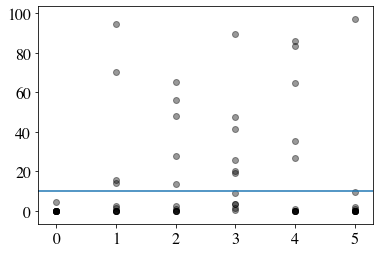

In [11]:
for trial in acceptable_trials: 
    for i in np.arange(0,len(columns)):
        percent_bootstrap[trial, columns[i]][0]
        plt.scatter(i, percent_bootstrap[trial, columns[i]][0], label = str(trial), alpha = .4, c = 'black')
plt.axhline(10)        
#plt.legend()
